In [4]:
## COMBINE P-VALUES ##

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

import sys, os
import re
from collections import defaultdict
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
from matplotlib.patches import Rectangle, Polygon
import seaborn as sns
sns.set_style('white')

import geneinfo as gi
gi.email('ariadna.saez@alum.esci.upf.edu')

def fisher_method_log10(pvalues):
    df = 2 * len(pvalues)
    return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


Merged file for LWK:
            pos  when_mutation_has_freq2         p
0       2781642                 0.082692  0.000000
1       2781865                 0.489434  0.257507
2       2781927                 1.083170  0.011587
3       2782572                 0.145357  0.446430
4       2783658                 0.610668  0.000000
...         ...                      ...       ...
82893  35307924                 0.516549  0.000000
82894  35307966                 0.718616  0.478302
82895  35308281                 0.554552  0.067767
82896  35308851                 0.196679  0.240979
82897  35309375                 0.196679  0.240979

[82898 rows x 3 columns]


/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


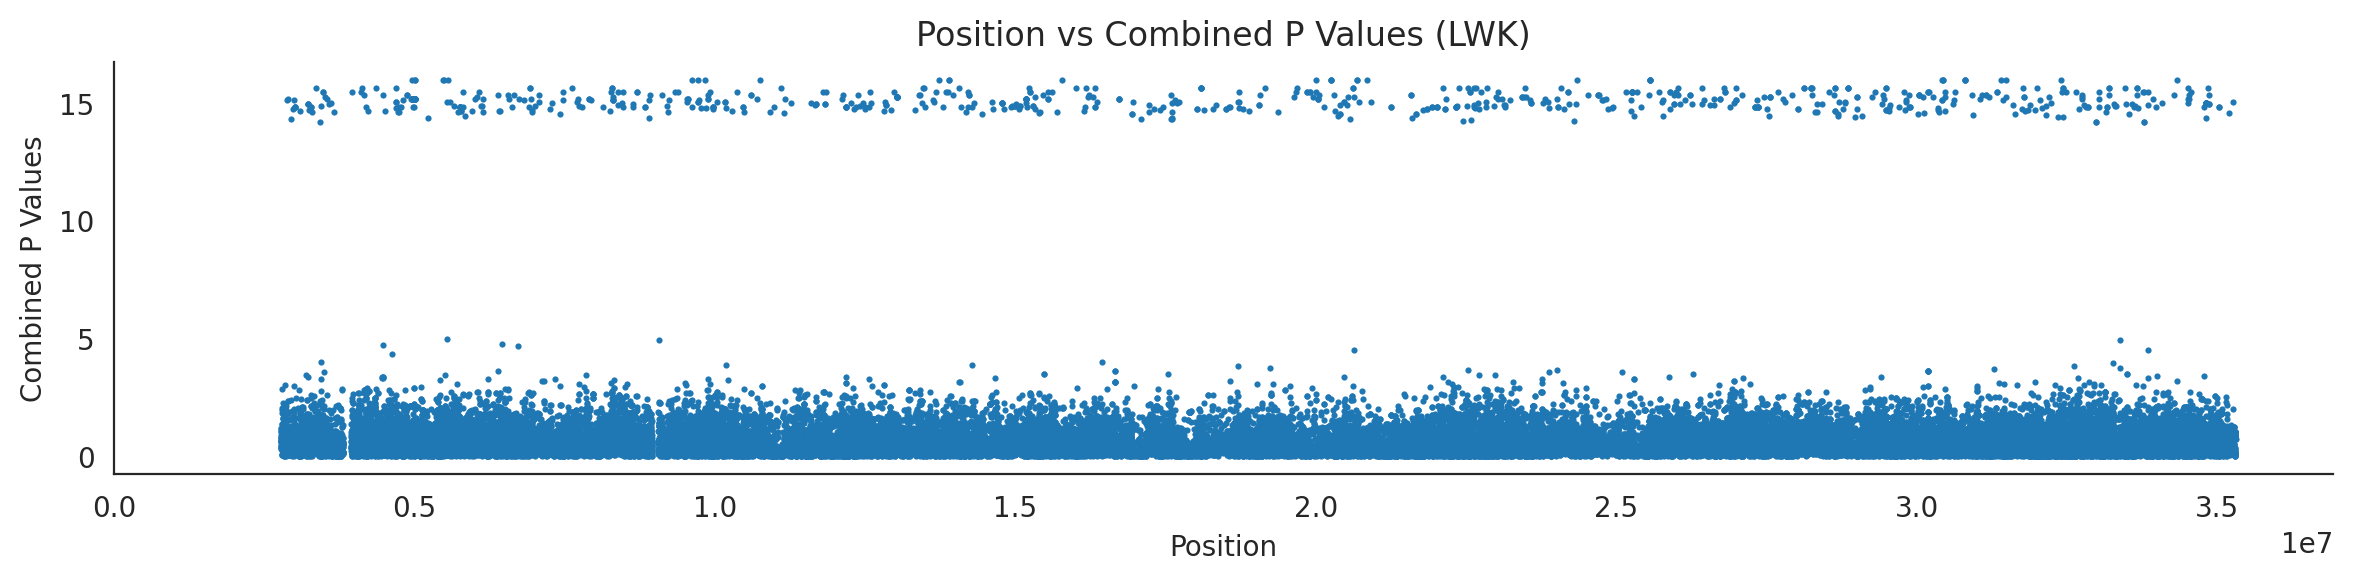

Merged file for ESN:
            pos  when_mutation_has_freq2         p
0       2781514                 0.471158  0.008299
1       2781584                 0.348030  0.493210
2       2781635                 1.050480  0.565561
3       2781642                 0.023204  0.000000
4       2781865                 0.916455  0.190400
...         ...                      ...       ...
89480  35697109                 0.934020  0.000000
89481  35697183                 0.200098  0.000000
89482  35697351                 0.627044  0.346621
89483  35697776                 2.124060  0.086413
89484  35697973                 0.627044  0.346621

[89485 rows x 3 columns]


/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


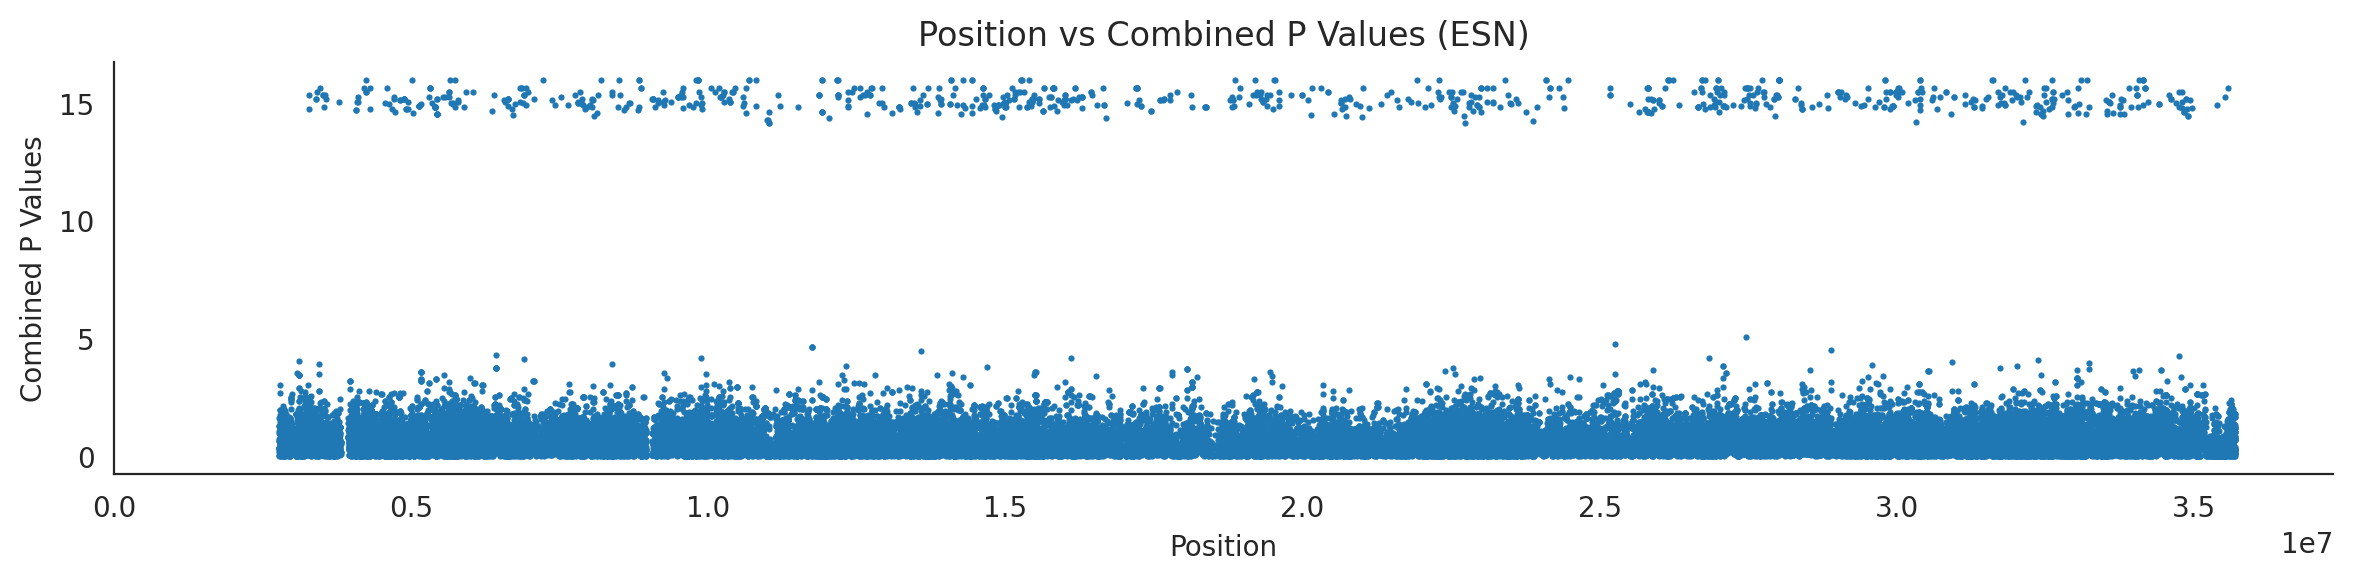

Merged file for GWD:
            pos  when_mutation_has_freq2         p
0       2781514                 0.775258  0.042963
1       2781584                 0.467748  0.203886
2       2781635                 2.461210  0.009646
3       2781642                 0.174437  0.000000
4       2781865                 3.034880  0.039289
...         ...                      ...       ...
92725  35697351                 0.321144  0.168169
92726  35697736                 0.153057  0.000000
92727  35697776                 1.746200  0.046149
92728  35697891                 0.128894  0.000000
92729  35697973                 0.321144  0.168169

[92730 rows x 3 columns]


/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


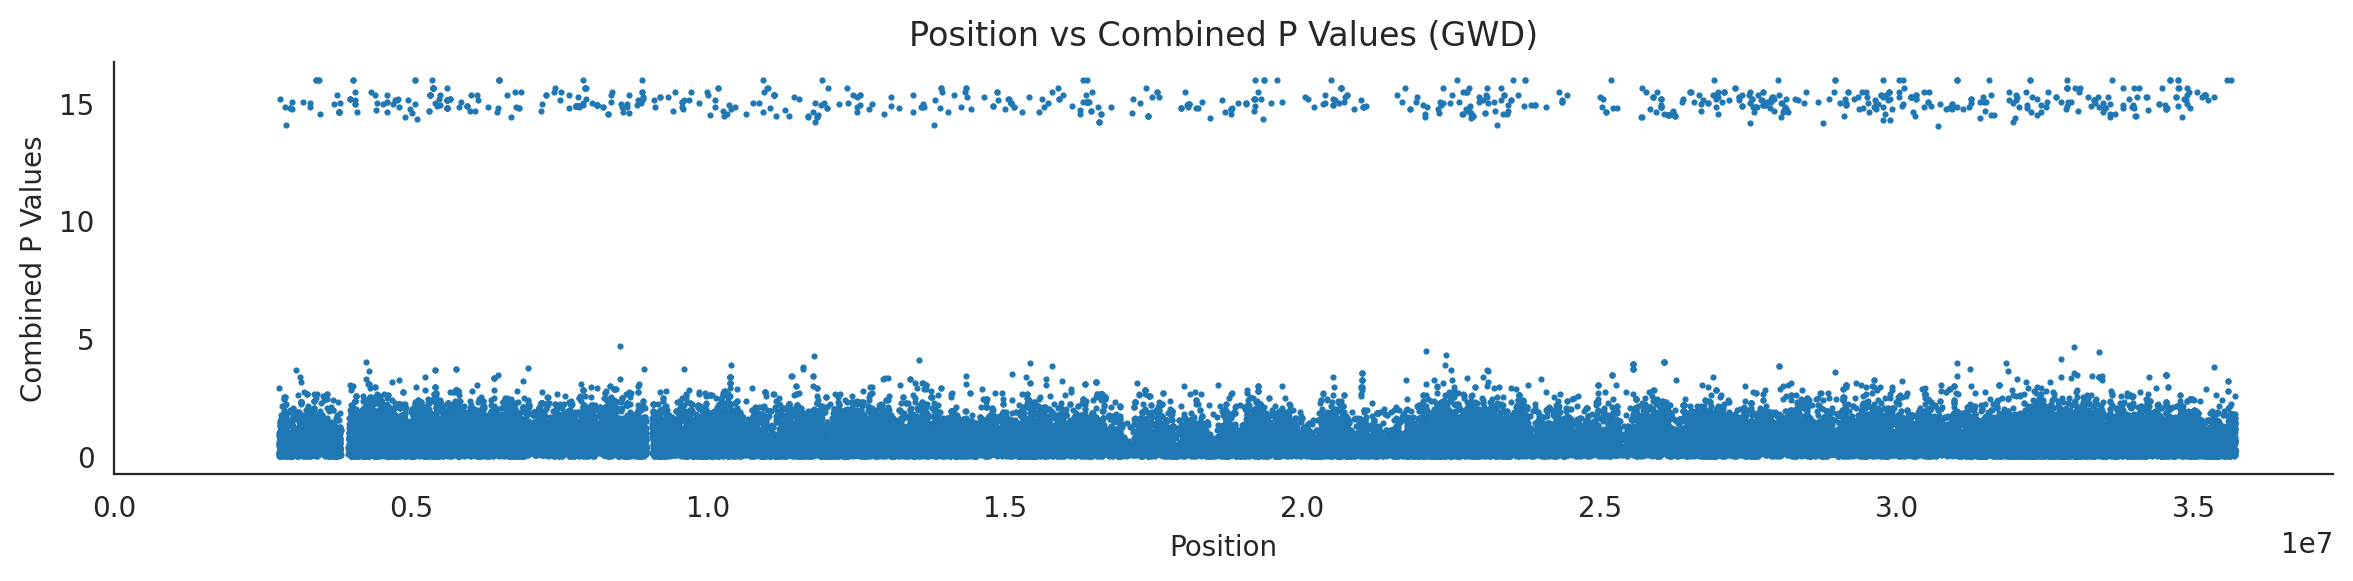

Merged file for MSL:
            pos  when_mutation_has_freq2         p
0       2781514                 0.117405  0.655683
1       2781584                 0.310528  0.029968
2       2781635                 0.672853  0.008203
3       2781865                 0.456151  0.239457
4       2781927                 0.676626  0.190015
...         ...                      ...       ...
82771  35697109                 0.103621  0.000000
82772  35697183                 0.151728  0.000000
82773  35697351                 0.071227  0.000000
82774  35697776                 1.803940  0.009450
82775  35697973                 0.071227  0.000000

[82776 rows x 3 columns]


/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


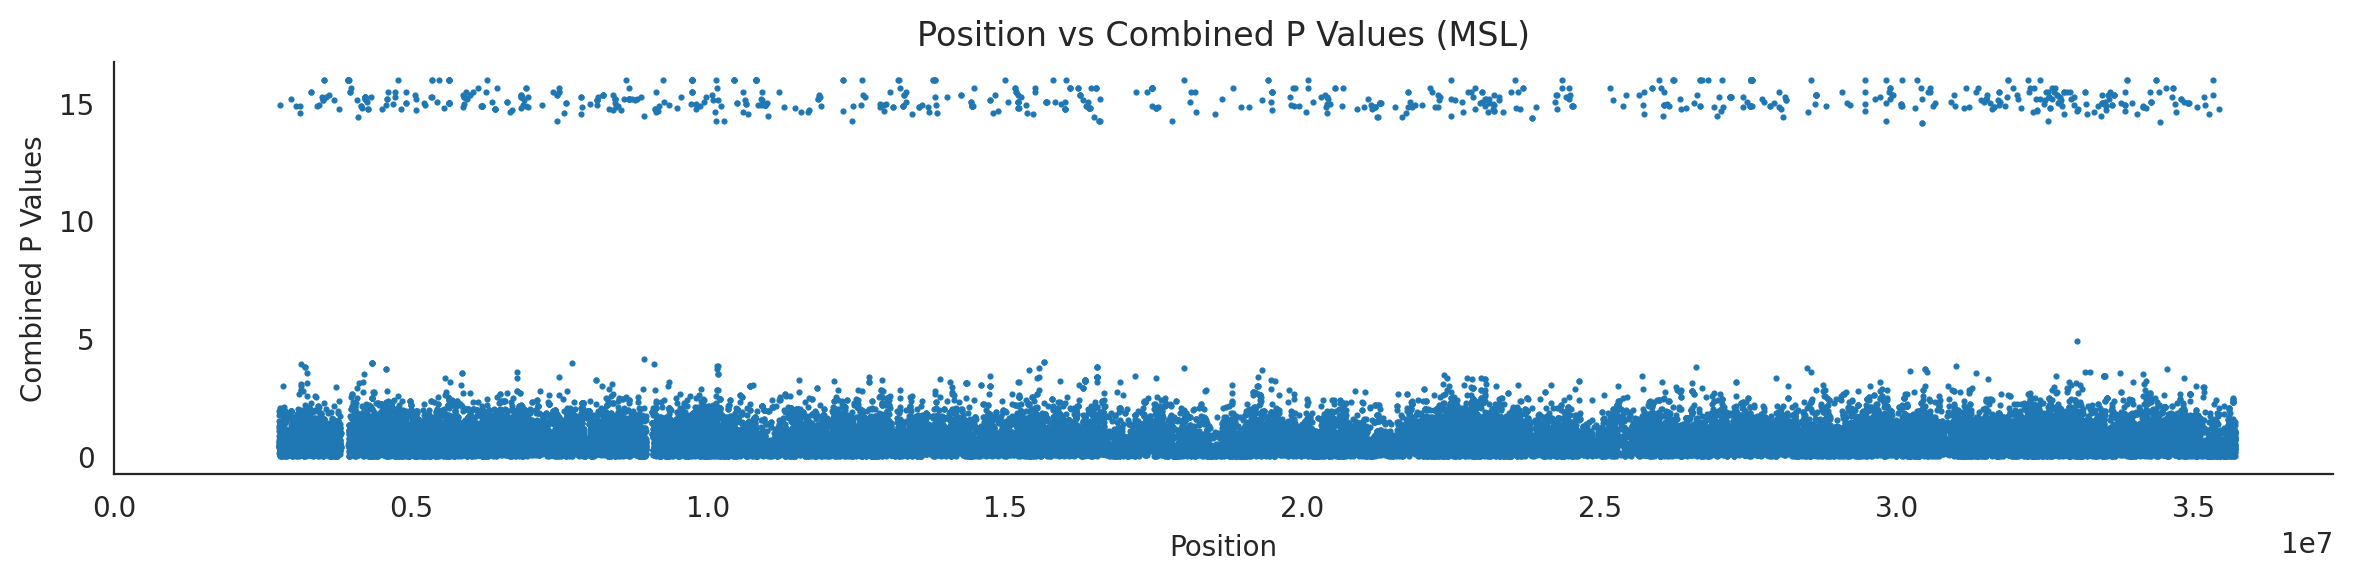

Merged file for YRI:
            pos  when_mutation_has_freq2         p
0       2781584                 0.250652  0.078739
1       2781635                 0.515658  0.085103
2       2781642                 0.133245  0.000000
3       2781927                 0.316513  0.126893
4       2782597                 0.168732  0.000000
...         ...                      ...       ...
94193  35697183                 0.002999  0.000000
94194  35697351                 0.351073  0.571949
94195  35697776                 2.276980  0.530511
94196  35697891                 0.238829  0.355484
94197  35697973                 0.351073  0.571949

[94198 rows x 3 columns]


/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


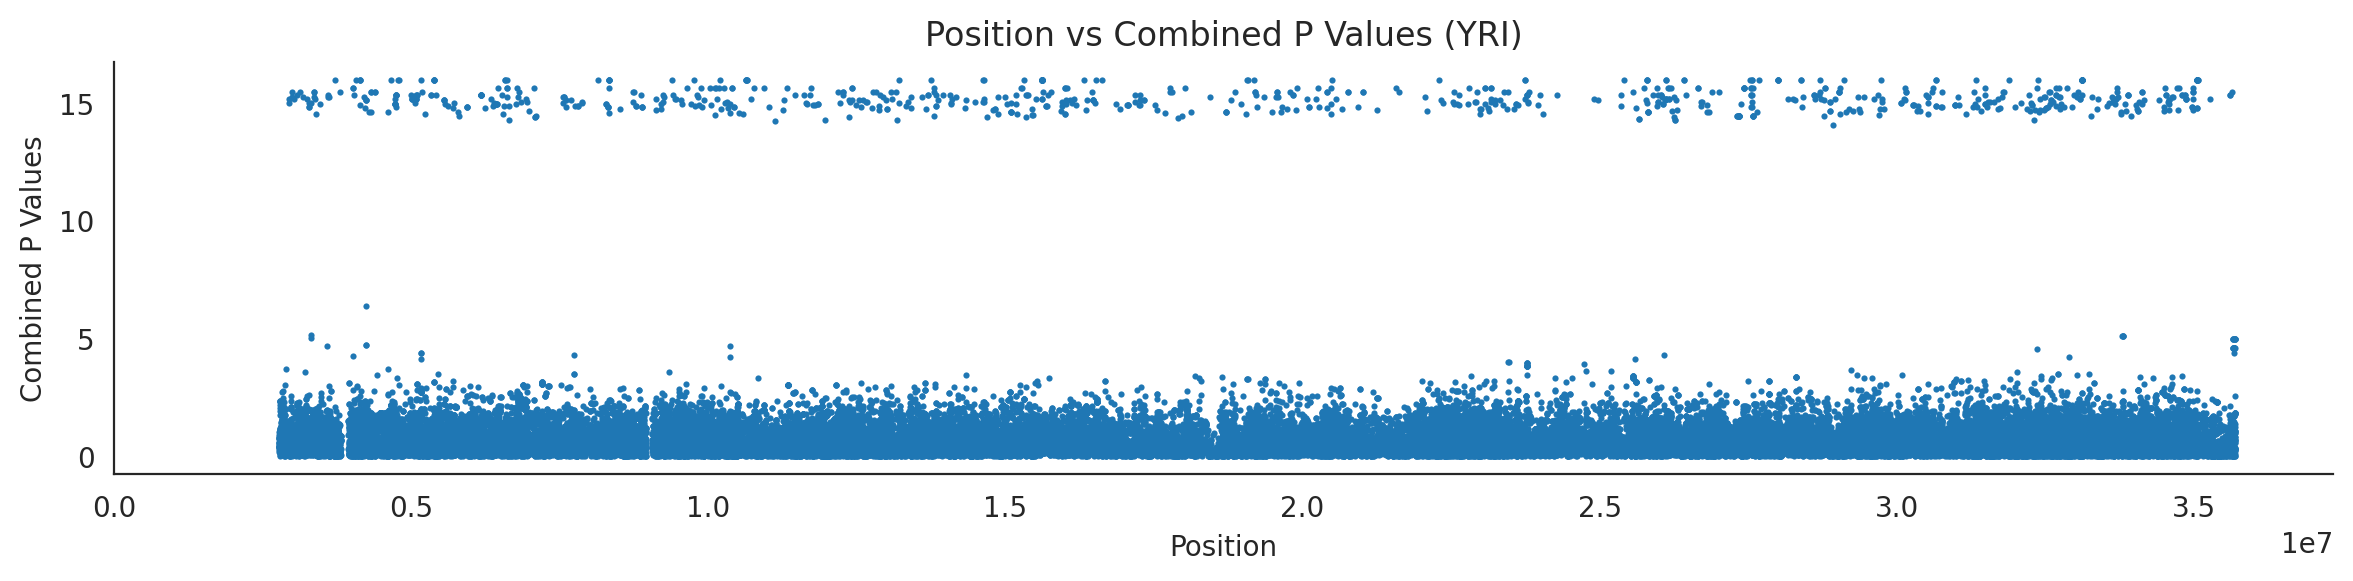

In [38]:
# List of populations and their file paths
populations = {
    # africans
    'LWK': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/LWK/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_LWK_runstats.h5"
    },
    'ESN': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/ESN/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_ESN_runstats.h5"
    },
    'GWD': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/GWD/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GWD_runstats.h5"
    },
    'MSL': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/MSL/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_MSL_runstats.h5"
    },
    'YRI': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/YRI/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_YRI_runstats.h5"
    }
}

for population, file_paths in populations.items():
    # Read files into DataFrames
    file1 = pd.read_csv(file_paths['relate'], sep=' ')
    file2 = pd.read_hdf(file_paths['kasper'])

    # Convert 'pos' column to integers in the second DataFrame (it had decimals)
    file2['pos'] = file2['pos'].astype(int)

    # Merge the two DataFrames on the 'pos' column
    merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')

    # Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
    merged_df['p'] = -np.log10(merged_df['p'])

    # Change negative values to positive in the second and last columns
    merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()
    
    print(f"Merged file for {population}:")
    print(merged_df)
    
    combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

    # Convert data to DataFrame
    df = pd.DataFrame(merged_df)

    # Combine p-values
    combined_p_values = df[['when_mutation_has_freq2', 'p']].apply(fisher_method_log10, axis=1)

    # Create a new DataFrame with pos and combined p-values
    new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})
    
    # Specify the file path including the directory and population name
    file_path = os.path.join("/home/ari/ari-intern/people/ari/ariadna-intern/results", f"combined_{population}.csv")
    
    # Save the DataFrame with the population name in the filename
    new_df.to_csv(file_path, index=False)

    # Plotting
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
    plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
    plt.xlabel('Position')
    plt.ylabel('Combined P Values')
    plt.title(f'Position vs Combined P Values ({population})')
    plt.tight_layout()
    sns.despine()
    plt.show()


/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


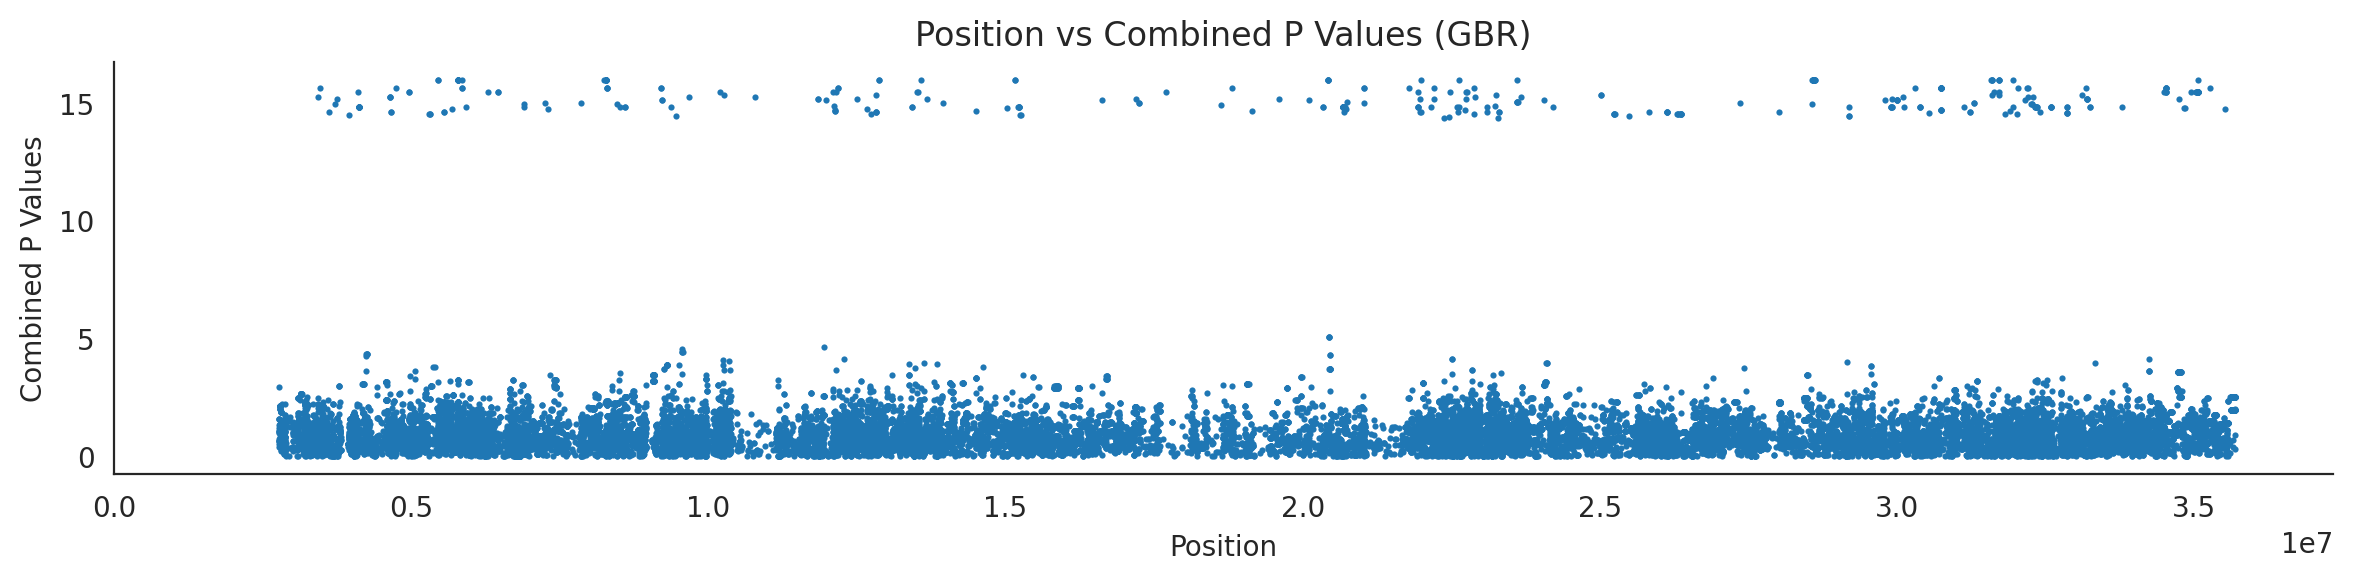

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


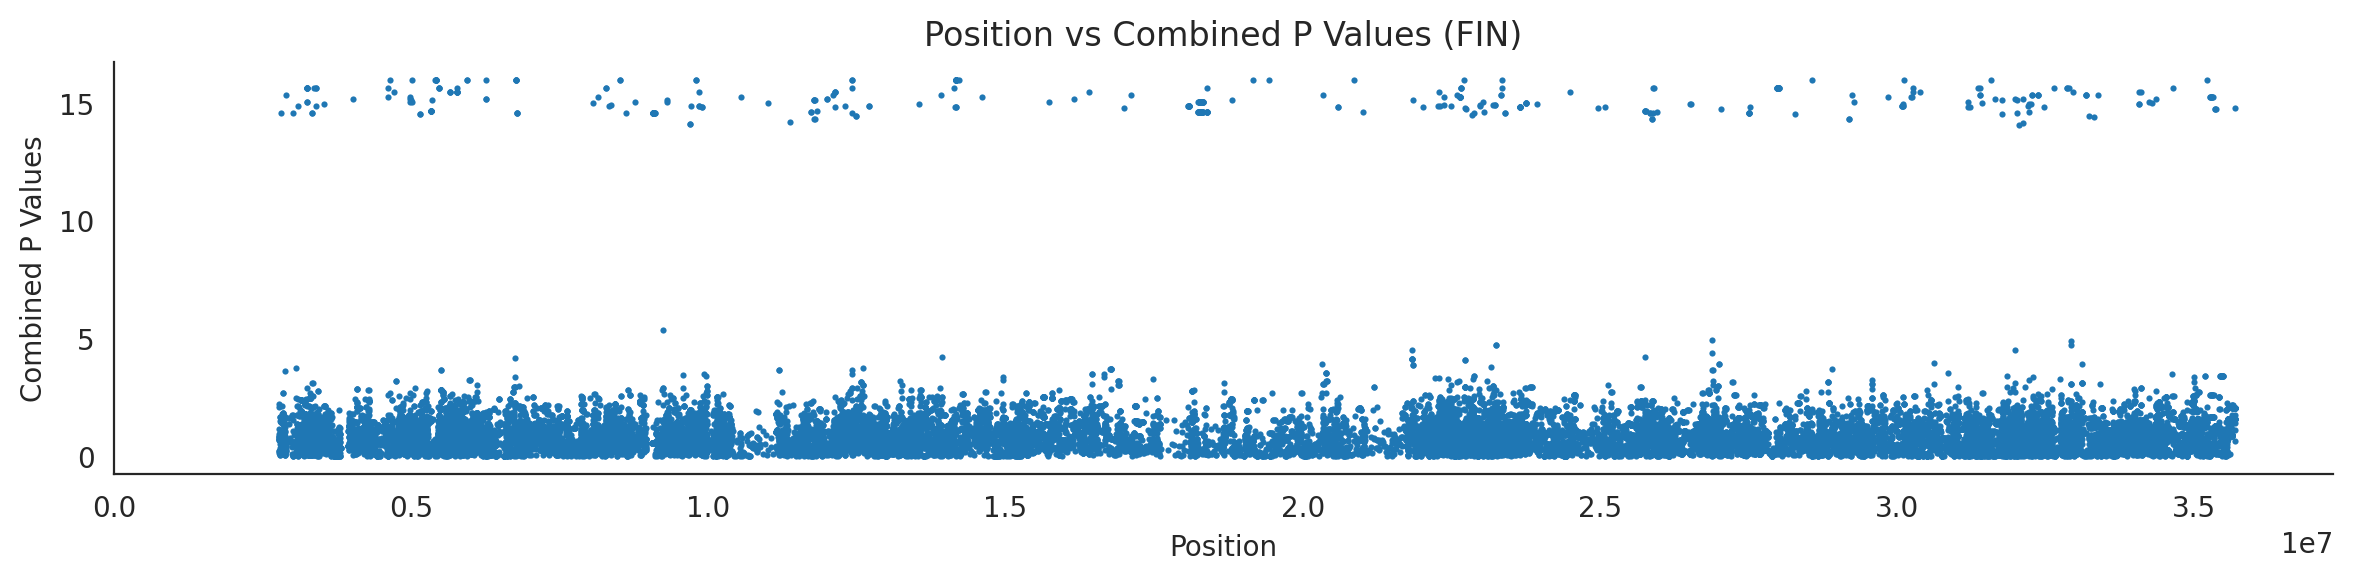

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


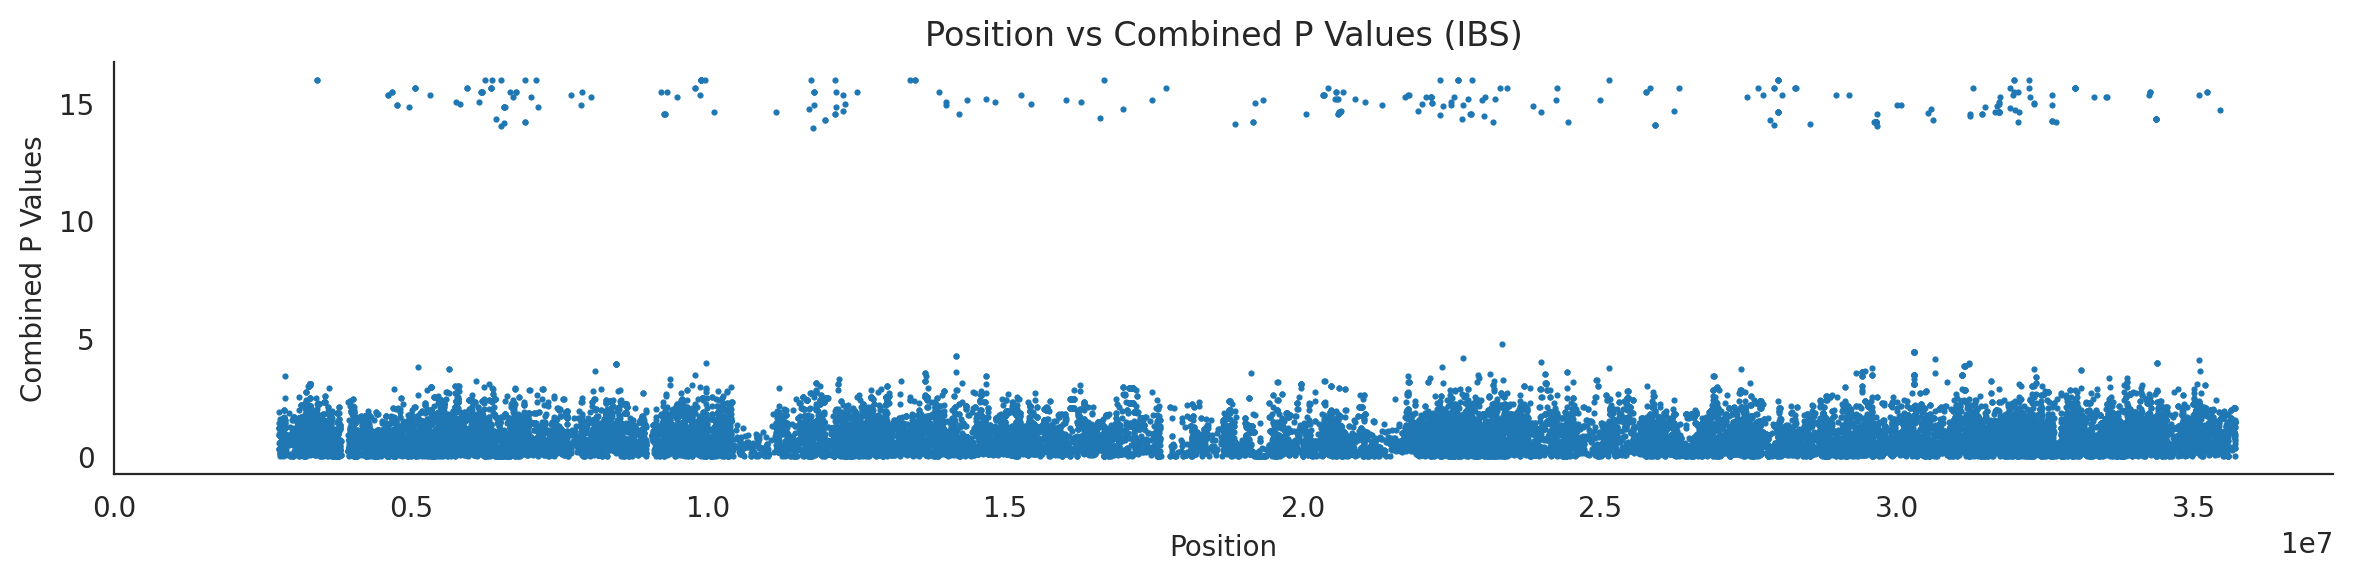

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


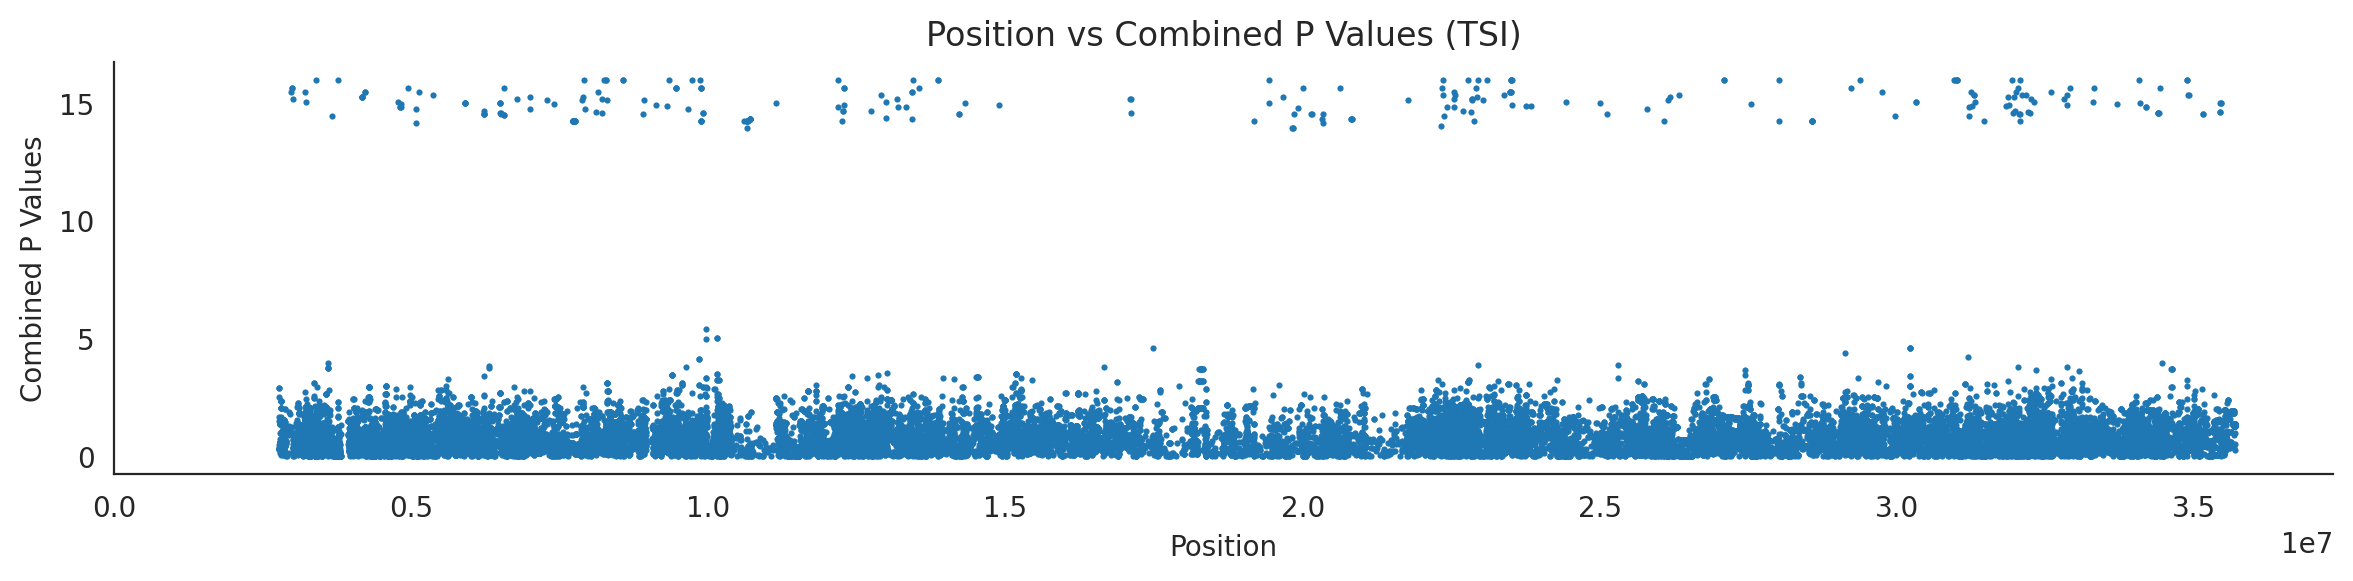

In [39]:
populations = {
    # europeans
    'GBR': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/GBR/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GBR_runstats.h5"
    },
    'FIN': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/FIN/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_FIN_runstats.h5"
    },
    'IBS': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/IBS/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_IBS_runstats.h5"
    },
    'TSI': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/TSI/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_TSI_runstats.h5"
    }
}


for population, file_paths in populations.items():
    # Read files into DataFrames
    file1 = pd.read_csv(file_paths['relate'], sep=' ')
    file2 = pd.read_hdf(file_paths['kasper'])

    # Convert 'pos' column to integers in the second DataFrame
    file2['pos'] = file2['pos'].astype(int)

    # Merge the two DataFrames on the 'pos' column
    merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')

    # Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
    merged_df['p'] = -np.log10(merged_df['p'])

    # Change negative values to positive in the second and last columns
    merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()

    combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

    # Convert data to DataFrame
    df = pd.DataFrame(merged_df)

    # Combine p-values
    combined_p_values = df[['when_mutation_has_freq2', 'p']].apply(fisher_method_log10, axis=1)

    # Create a new DataFrame with pos and combined p-values
    new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})
    
     # Specify the file path including the directory and population name
    file_path = os.path.join("/home/ari/ari-intern/people/ari/ariadna-intern/results", f"combined_{population}.csv")
    
    # Save the DataFrame with the population name in the filename
    new_df.to_csv(file_path, index=False)

    # Plotting
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
    plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
    plt.xlabel('Position')
    plt.ylabel('Combined P Values')
    plt.title(f'Position vs Combined P Values ({population})')
    plt.tight_layout()
    sns.despine()
    plt.show()

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


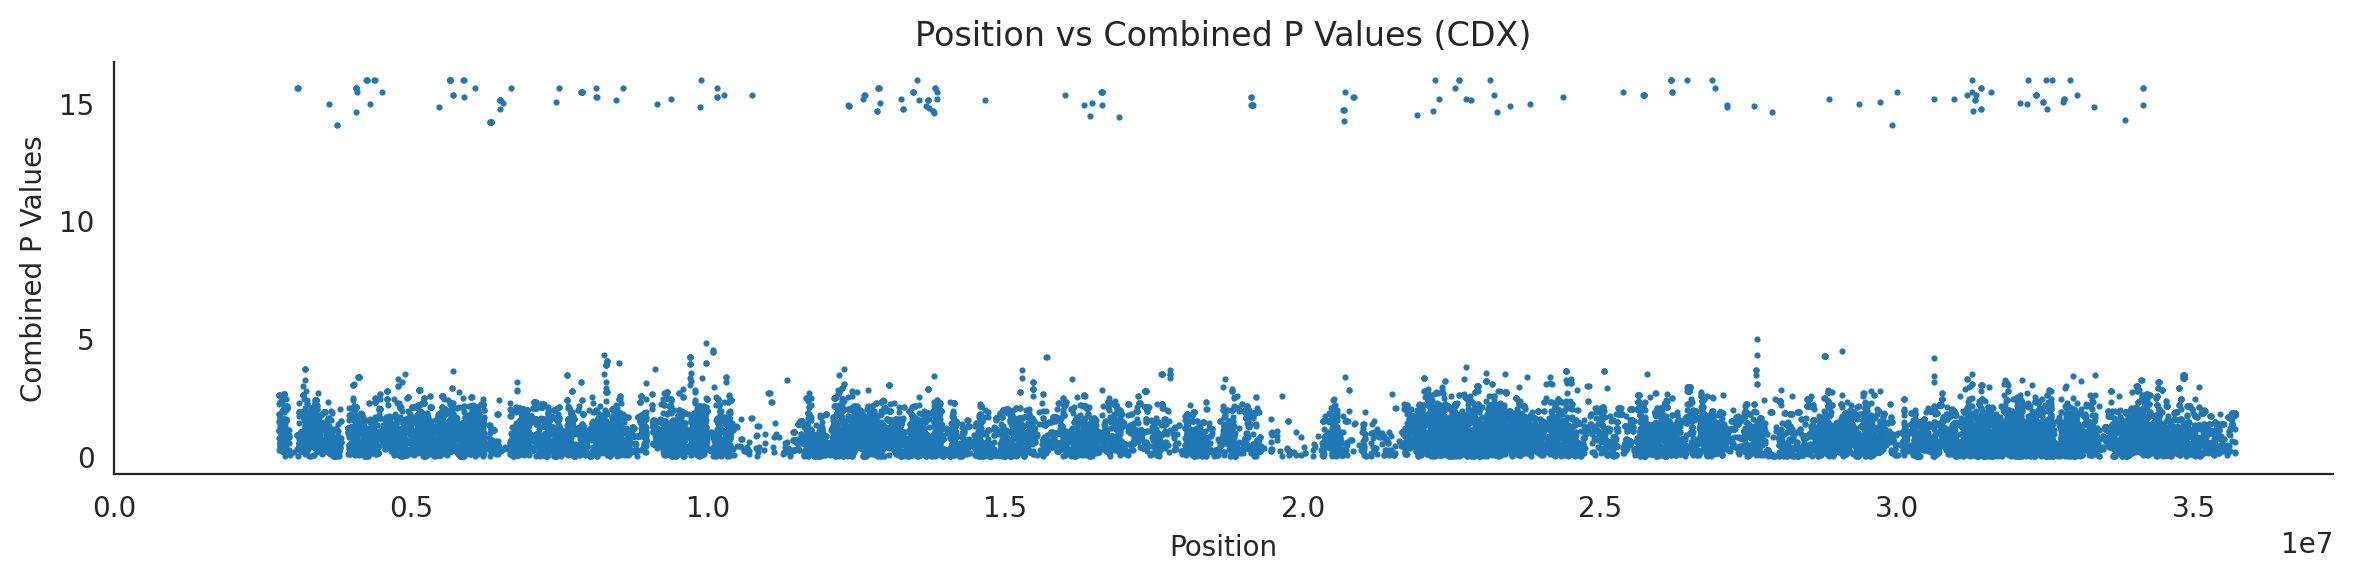

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


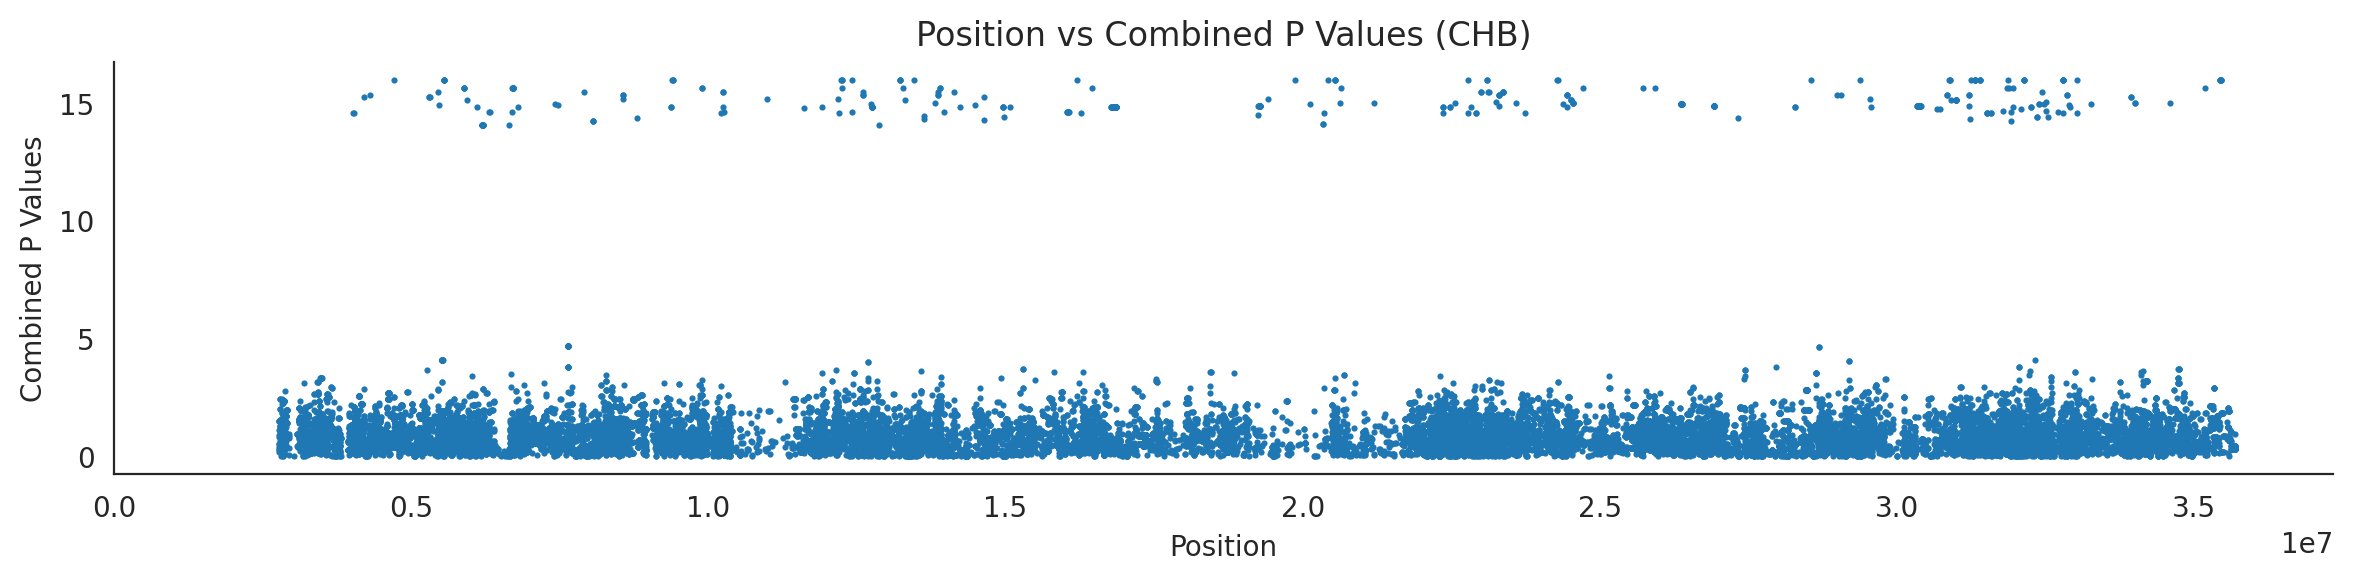

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


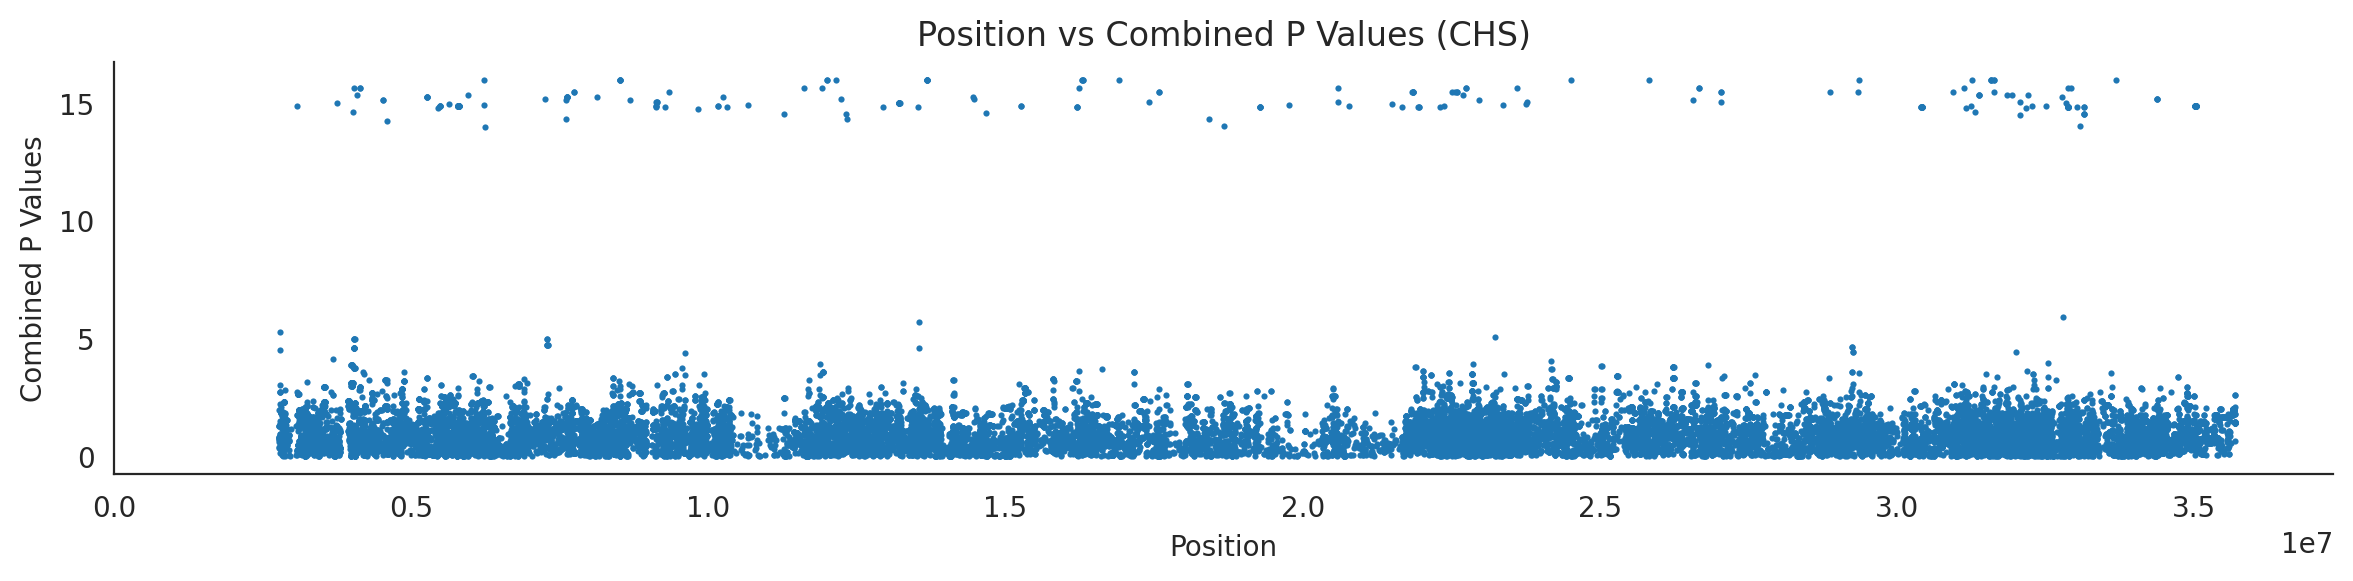

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


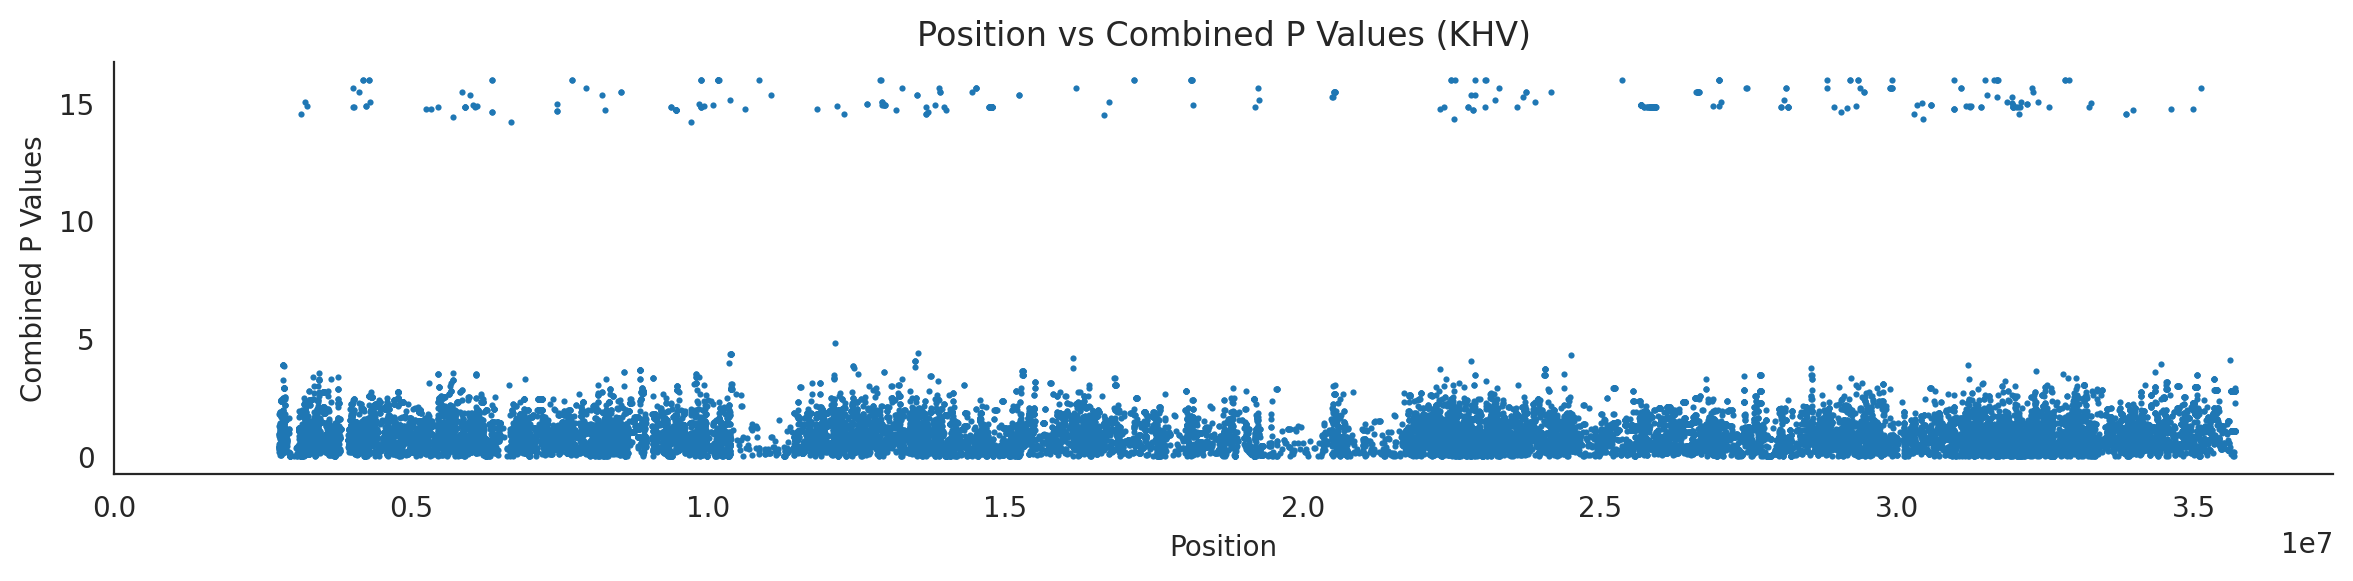

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


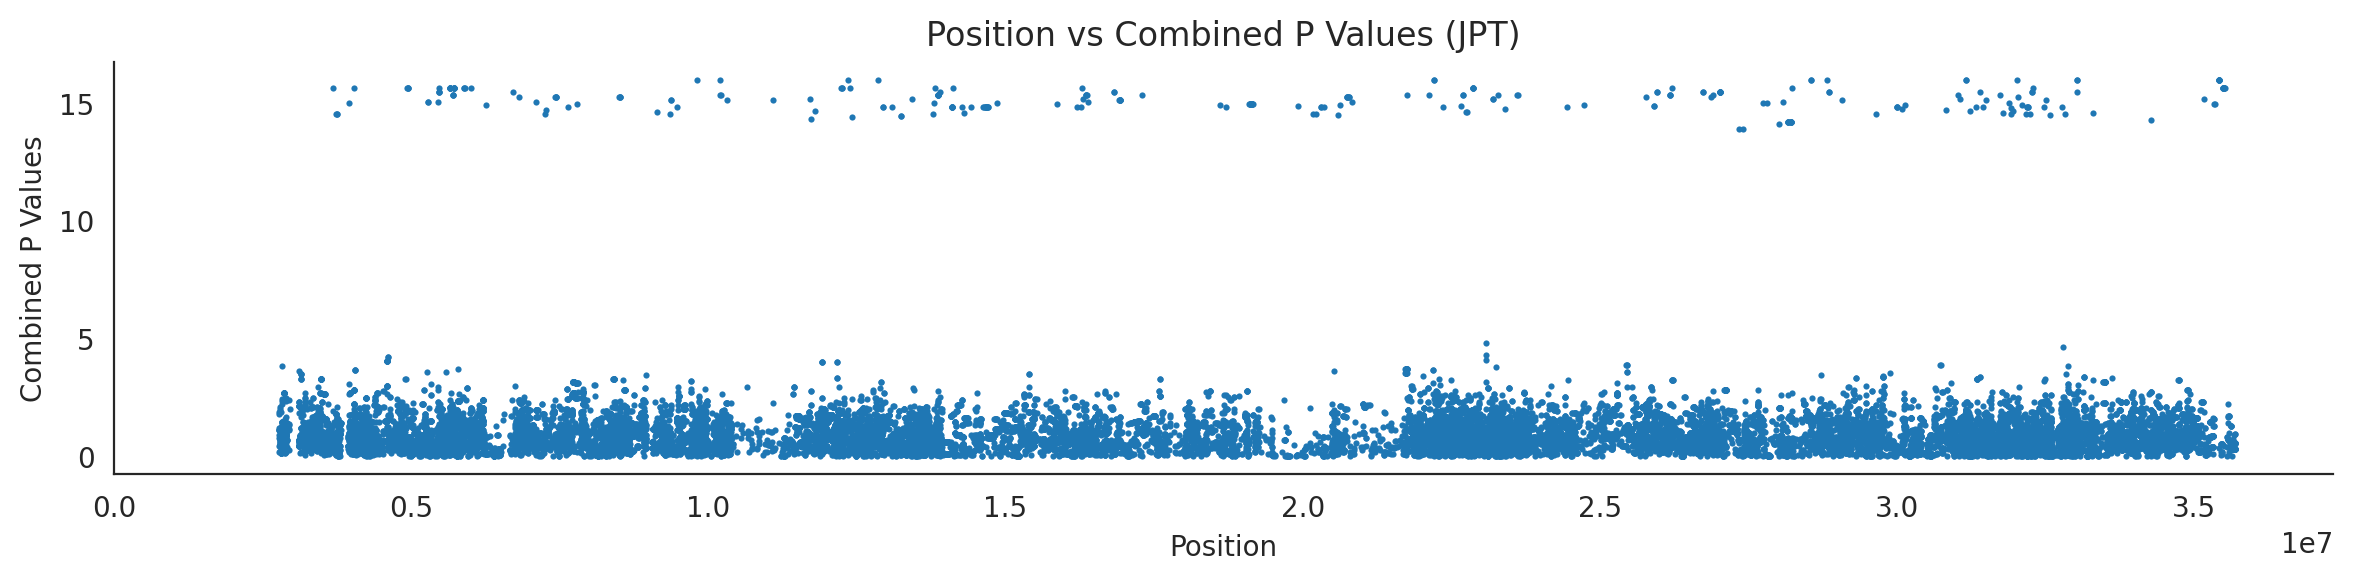

In [40]:
populations = {
    # asians
    'CDX': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/CDX/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CDX_runstats.h5"
    },
    'CHB': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHB/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHB_runstats.h5"
    },
    'CHS': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHS/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHS_runstats.h5"
    },
    'KHV': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/KHV/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_KHV_runstats.h5"
    },
    'JPT': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/JPT/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_JPT_runstats.h5"
    }
}

# Iterate over populations
for population, file_paths in populations.items():
    # Read files into DataFrames
    file1 = pd.read_csv(file_paths['relate'], sep=' ')
    file2 = pd.read_hdf(file_paths['kasper'])

    # Convert 'pos' column to integers in the second DataFrame
    file2['pos'] = file2['pos'].astype(int)

    # Merge the two DataFrames on the 'pos' column
    merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')

    # Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
    merged_df['p'] = -np.log10(merged_df['p'])

    # Change negative values to positive in the second and last columns
    merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()

    combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

    # Convert data to DataFrame
    df = pd.DataFrame(merged_df)

    # Combine p-values
    combined_p_values = df[['when_mutation_has_freq2', 'p']].apply(fisher_method_log10, axis=1)

    # Create a new DataFrame with pos and combined p-values
    new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})
    
    # Specify the file path including the directory and population name
    file_path = os.path.join("/home/ari/ari-intern/people/ari/ariadna-intern/results", f"combined_{population}.csv")
    
    # Save the DataFrame with the population name in the filename
    new_df.to_csv(file_path, index=False)

    # Plotting
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
    plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
    plt.xlabel('Position')
    plt.ylabel('Combined P Values')
    plt.title(f'Position vs Combined P Values ({population})')
    plt.tight_layout()
    sns.despine()
    plt.show()